In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import numpy as np
import requests
import datetime
import pycountry as pc
import math

# countries_list = ["DK", "FI", "NO", "SE"]
countries_list = ["AT", "BE", "BG", "CH", "CZ", "DE", "DK", "EE", "ES", "FI", "FR", "HU", "IT", "IS", "LT", "LV", "LU", "NL", "NO", "PL", "PT", "SE", "SK", "UK"]
a3_countries_list = []
if "UK" in countries_list:
    for country in countries_list[:-1]:
        a3_countries_list.append(pc.countries.get(alpha_2=country).alpha_3)
    a3_countries_list.append("GBR")
else:
    for country in countries_list:
        a3_countries_list.append(pc.countries.get(alpha_2=country).alpha_3)
# a3_countries_list.append("ENG_UK")
print(a3_countries_list)
print(len(countries_list), len(a3_countries_list))
download_data = False
# folder_eu = "https://ec.europa.eu/eurostat/databrowser-backend/api/extraction/1.0/LIVE/true/"
# file_eu = "csv/DEMO_R_MWK_TS$DEFAULTVIEW"
# file_eu = "csv/DEMO_MMONTH__custom_26121"
# file_eu = "csv/DEMO_R_MWK_TS__custom_26098"

# folder_uk = "https://www.ons.gov.uk/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/datasets/weeklyprovisionalfiguresondeathsregisteredinenglandandwales/"

# weeknr = datetime.date(2010, 6, 16).isocalendar()[1]
# filelist_uk = []
# for year in range(2010, 2021):
#     if year >= 2020:
#         filelist_uk.append("{0}/publishedweek{1}{0}.xlsx".format(year, 38))
#     if 2019 >= year > 2016:
#         filelist_uk.append("{0}/publishedweek52{0}.xls".format(year))
#     if 2016 >= year:
#         filelist_uk.append("{0}/publishedweek{0}.xls".format(year))

# filelist_uk = ["2020/publishedweek382020.xlsx", "2019/publishedweek522020.xls", 
#                 "2018/publishedweek522020.xls", "2017/publishedweek522020.xls", 
#                 "2016/publishedweek522020.xls", "2015/publishedweek2020.xls", 
#                 "2014/publishedweek2014.xls", "2013/publishedweek2020.xls", 
#                 "2012/publishedweek2012.xls", "2011/publishedweek2020.xls"]


# file_uk = "2020/publishedweek382020.xlsx"

# filelist_uk

# if download_data:
#     requests.get(url).content



# Constants and defaults:
lockdown_treshold = 40
avg_margin = 3



['AUT', 'BEL', 'BGR', 'CHE', 'CZE', 'DEU', 'DNK', 'EST', 'ESP', 'FIN', 'FRA', 'HUN', 'ITA', 'ISL', 'LTU', 'LVA', 'LUX', 'NLD', 'NOR', 'POL', 'PRT', 'SWE', 'SVK', 'GBR']
24 24


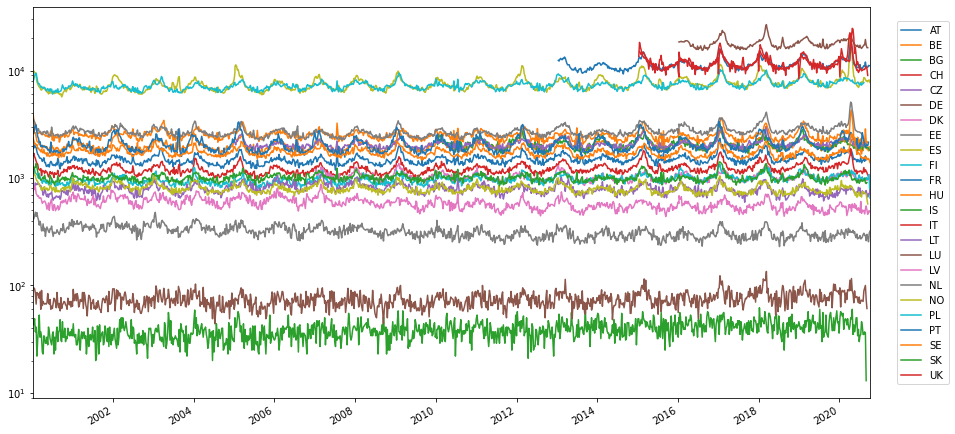

In [2]:
folder_eu_weekly = "https://ec.europa.eu/eurostat/databrowser-backend/api/extraction/1.0/LIVE/true/"
# file_eu_weekly = "csv/DEMO_R_MWK_TS$DEFAULTVIEW"
# file_eu_weekly = "csv/DEMO_MMONTH__custom_26121"
# file_eu_weekly = "csv/DEMO_R_MWK_10__custom_32605"
file_eu_weekly = "csv/DEMO_R_MWK_TS__custom_26098"
eu_weekly_df = pd.read_csv(folder_eu_weekly + file_eu_weekly, sep='[",",";"]', engine="python", parse_dates=True)
eu_weekly_df.rename(columns = {'geo\TIME_PERIOD':'geo'}, inplace=True)
eu_weekly_df.replace(r':', np.NaN, regex=True, inplace=True)
# eu_weekly_df.fillna(0, inplace = True)
eu_weekly_df.replace([r'p$', r'e$'], [r'']*2, regex=True, inplace=True)
# eu_weekly_df.replace([r'e$'], [r''], regex=True, inplace=True)
eu_weekly_df = eu_weekly_df[(eu_weekly_df["sex"]=="T") & (eu_weekly_df["geo"].isin(countries_list))]
w99_list = ["{}-W99 ".format(i) for i in range(2000, 2019)]
eu_weekly_df.drop(columns=["freq", "unit", "sex"] + w99_list, inplace=True)

eu_weekly_df = eu_weekly_df.T
eu_weekly_df.columns = eu_weekly_df.loc["geo"]
eu_weekly_df.drop(["geo"], inplace=True)
eu_weekly_df = eu_weekly_df.apply(pd.to_numeric)
ri = [i.rstrip() + "-0" for i in eu_weekly_df.index]
eu_weekly_df.index = pd.to_datetime(ri, format="%Y-W%W-%w")
eu_weekly_df.loc[:].plot(figsize=(15,8))
scale = "log"
plt.yscale(scale)
plt.legend(loc="right", bbox_to_anchor=(1.1, 0.5))
plt.savefig("figs/mortality_{}.pdf".format(scale))


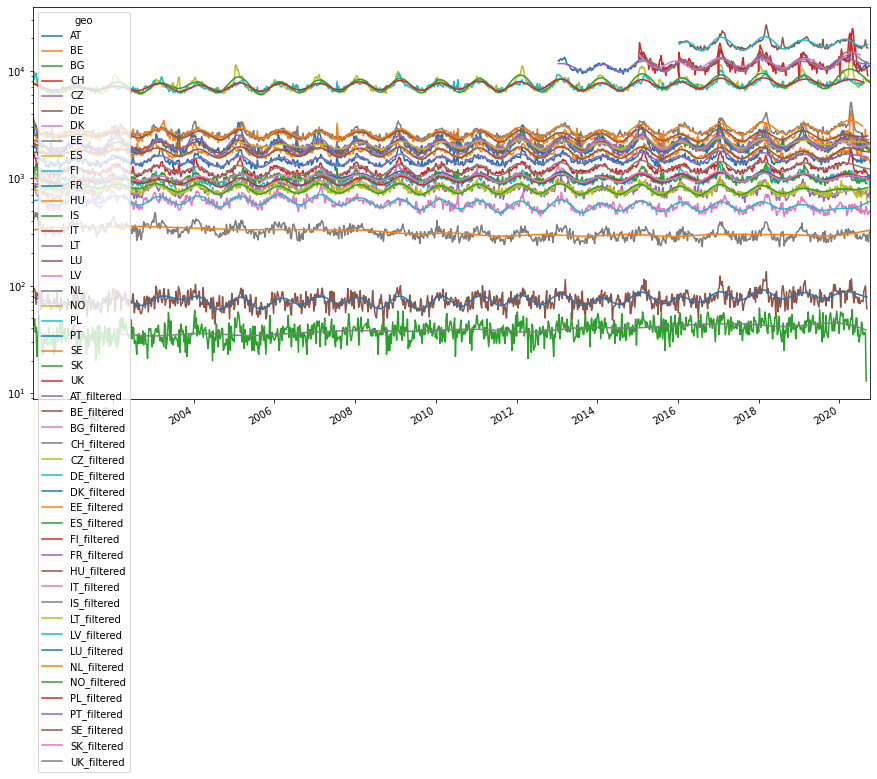

In [3]:
spectral_analysis = True
def round_up(n, decimals=0):
    multiplier = 10 ** decimals
    return math.ceil(n * multiplier) / multiplier

if spectral_analysis:
    eu_weekly_filtered_df = eu_weekly_df
    for country in countries_list:
        mask = np.isfinite(eu_weekly_df[country])

        spec = np.fft.fft(eu_weekly_df[country][mask])
        t = np.arange(len(eu_weekly_df[country][mask]))
        freq = np.fft.fftfreq(t.shape[-1])
        power = np.absolute(spec)**2
        
        # Find Peak
        pos_mask = np.where(freq > 0)
        freq_masked = freq[pos_mask]
        peak_freq = freq_masked[power[pos_mask].argmax()]
        
        # Filter
        precision = 2
        low_pass_filter = round_up(peak_freq, precision) # + 1*10**(-precision)
        filter_spec = spec.copy()
        # filter_spec[np.abs(freq - peak_freq) > low_pass_filter] = 0
        filter_spec[np.absolute(freq) > low_pass_filter] = 0
        filtered_sig = np.fft.ifft(filter_spec)
        
        # print(np.real(filtered_sig))
        
        eu_weekly_df[country+"_filtered"] = eu_weekly_df[country]
        #eu_weekly_df[country+"_filtered"].loc[mask] = filtered_sig
        eu_weekly_df.loc[mask, country+"_filtered"] = np.real(filtered_sig)
        #eu_weekly_filtered_df[country][mask] = filtered_sig
        
        # eu_weekly_df[country].sub(eu_weekly_df[country + "_filtered"], axis=0).plot(figsize=(15,8))
eu_weekly_df.plot(figsize=(15,8))
scale = "log"
plt.yscale(scale)
plt.savefig("figs/mortality_and_fourier_{}.pdf".format(scale))

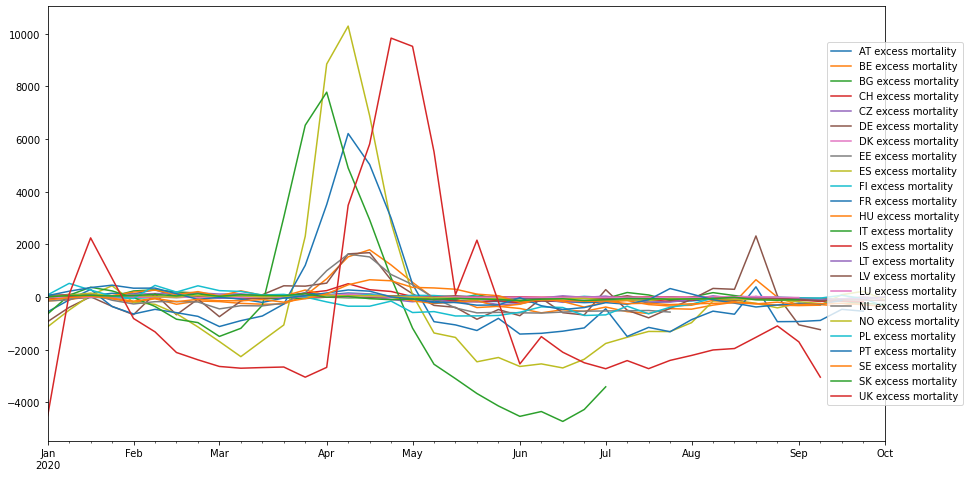

In [4]:
fig, ax = plt.subplots()
view_start = "2020-01"
for country in countries_list:
    eu_weekly_df[country].loc[view_start:].sub(eu_weekly_df[country + "_filtered"].loc[view_start:], axis=0).plot(figsize=(15,8), ax=ax, label="{} excess mortality".format(country))

# plt.yscale("log")
plt.legend(loc="right", bbox_to_anchor=(1.1, 0.5))
plt.savefig("figs/excess_mortality_fourier.pdf")

# plt.figure(figsize=(15,8))
# plt.axvline(low_pass_filter)
# plt.axvline(-low_pass_filter)
# plt.plot(freq, spec.real, freq, spec.imag)#, freq, power)

#plt.yscale("log")
#plt.legend(loc="right", bbox_to_anchor=(1.1, 0.5))

In [5]:
for country in countries_list:
    eu_weekly_df[country].loc[view_start:].sub(eu_weekly_df[country + "_filtered"].loc[view_start:], axis=0).plot(figsize=(15,8), ax=ax, label="{} excess mortality".format(country))


In [6]:
folder_eu_daily = "https://opendata.ecdc.europa.eu/covid19/casedistribution/"
file_eu_daily = "csv"
date_parser_daily = lambda x: pd.datetime.strptime(str(x), "%d/%m/%Y")
eu_daily_df = pd.read_csv(folder_eu_daily + file_eu_daily, index_col="dateRep", parse_dates=["dateRep"], date_parser=date_parser_daily)
def moving_avg(data, avg_margin=avg_margin):
    return [0]*avg_margin + [sum(data[i-avg_margin:i+avg_margin+1])/(1+2*avg_margin) for i in range(avg_margin, len(data)-avg_margin)] + [0]*avg_margin
# eu_daily_df["deaths_smooth"] = moving_avg(eu_daily_df["deaths"])
# eu_daily_df

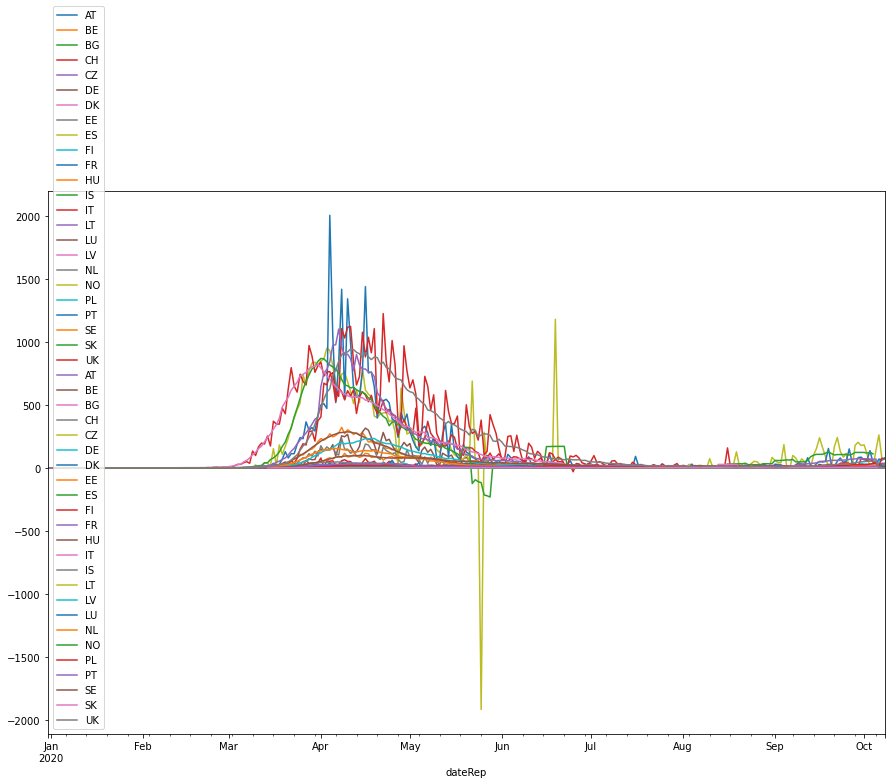

In [7]:
deaths_daily_df = eu_daily_df[eu_daily_df["geoId"].isin(countries_list)].groupby(["dateRep","geoId"]).sum()["deaths"].unstack()
deaths_daily_smooth_df = pd.DataFrame()
for nation in countries_list:
    deaths_daily_smooth_df[nation] = moving_avg(deaths_daily_df[nation])
deaths_daily_smooth_df.index = deaths_daily_df.index 

ax = deaths_daily_df.plot(figsize=(15,10))
deaths_daily_smooth_df.plot(figsize=(15,10), ax=ax)
plt.legend(loc="lower left")
plt.savefig("figs/daily_eu_deaths.pdf")
# There is obviously an error in the spanish data here... this error is also present in the JHU data.

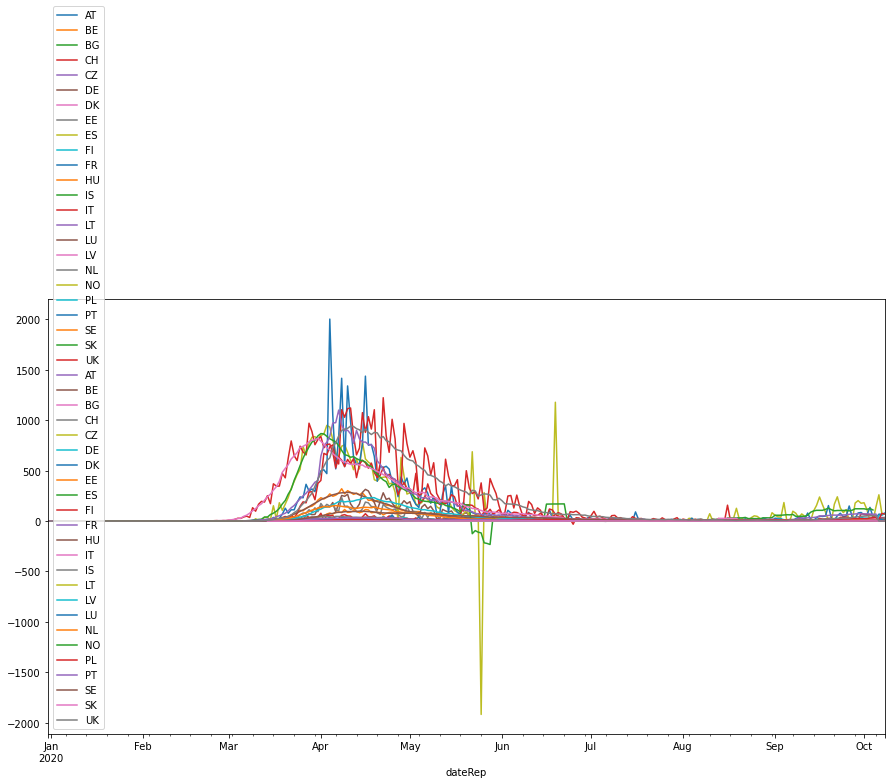

In [8]:
# eu_daily_df[eu_daily_df["geoId"]=="ES"].loc["2020-05":"2020-06"]# and eu_daily_df["deaths"]<0]
# eu_daily_df[eu_daily_df["geoId"].isin(countries_list)].groupby(["dateRep","geoId"]).sum()["deaths"].unstack().plot(figsize=(15,8))
ax = deaths_daily_df.plot(figsize=(15,8))
deaths_daily_smooth_df.plot(figsize=(15,8), ax=ax)
# plt.ylim(0,2000)
plt.legend(loc="lower left")
plt.savefig("figs/daily_eu_deaths_nice_axis.pdf")

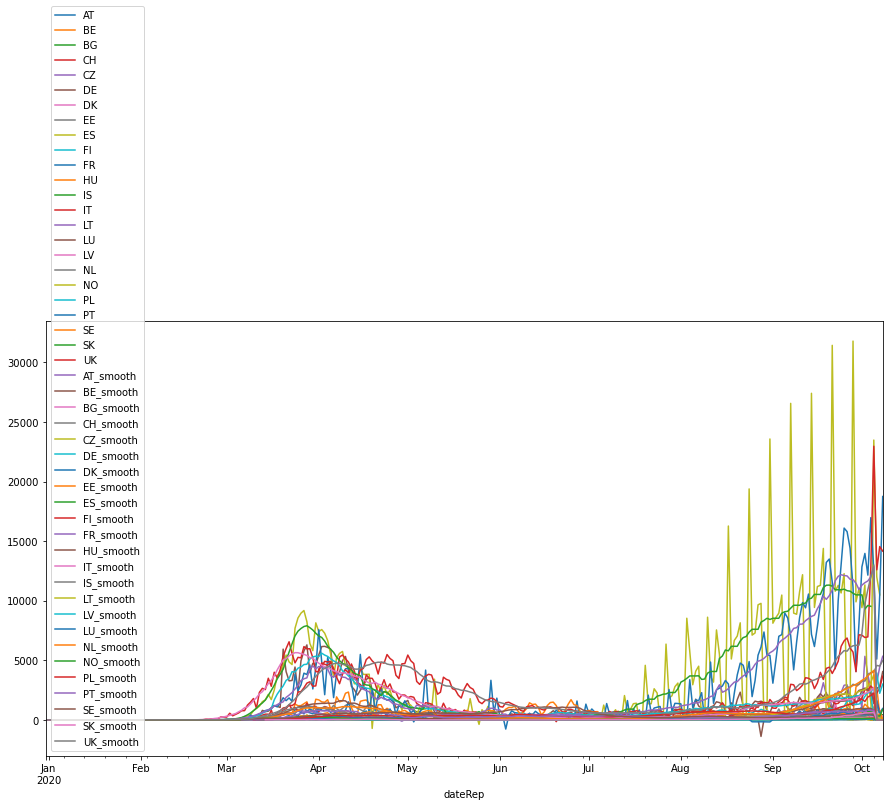

In [9]:
cases_daily_df = eu_daily_df[eu_daily_df["geoId"].isin(countries_list)].groupby(["dateRep","geoId"]).sum()["cases"].unstack()
for nation in countries_list:
    cases_daily_df[nation + "_smooth"] = moving_avg(cases_daily_df[nation])
cases_daily_df.plot(figsize=(15,8))
# plt.ylim(0,2000)
plt.legend(loc="lower left")
plt.savefig("figs/daily_eu_cases_nice_axis.pdf")
# eu_daily_df

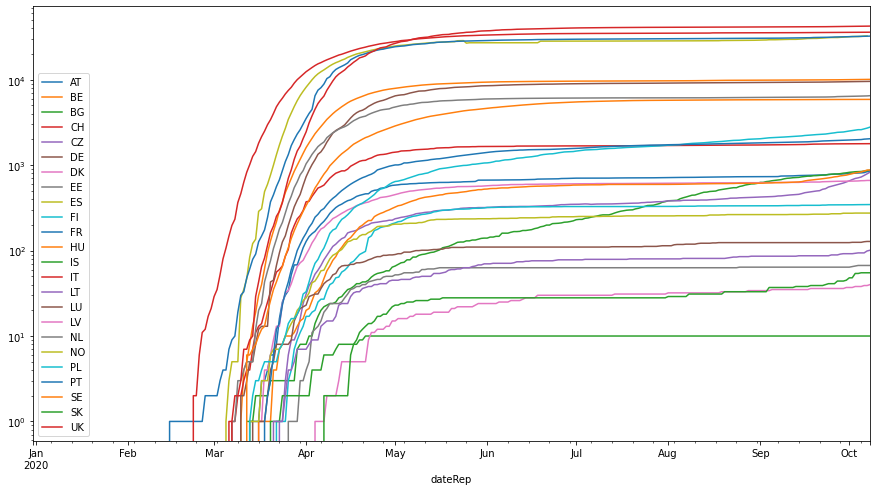

In [10]:
eu_daily_df[eu_daily_df["geoId"].isin(countries_list)].groupby(["dateRep","geoId"]).sum()["deaths"].unstack().cumsum().plot(figsize=(15,8))
plt.yscale("log")
plt.legend(loc="lower left")
plt.savefig("figs/cumulated_eu_deaths_nice_axis.pdf")

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,CountryName,CountryCode,RegionName,RegionCode,C1_School closing,C1_Flag,C2_Workplace closing,C2_Flag,C3_Cancel public events,C3_Flag,...,StringencyIndex,StringencyIndexForDisplay,StringencyLegacyIndex,StringencyLegacyIndexForDisplay,GovernmentResponseIndex,GovernmentResponseIndexForDisplay,ContainmentHealthIndex,ContainmentHealthIndexForDisplay,EconomicSupportIndex,EconomicSupportIndexForDisplay
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,Aruba,ABW,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,...,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0
2020-01-02,Aruba,ABW,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,...,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0
2020-01-03,Aruba,ABW,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,...,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0
2020-01-04,Aruba,ABW,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,...,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0
2020-01-05,Aruba,ABW,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,...,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-04,Zimbabwe,ZWE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,76.85,NaN,84.52,NaN,63.46,NaN,70.45,NaN,25.0
2020-10-05,Zimbabwe,ZWE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,76.85,NaN,84.52,NaN,63.46,NaN,70.45,NaN,25.0
2020-10-06,Zimbabwe,ZWE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,76.85,NaN,84.52,NaN,63.46,NaN,70.45,NaN,25.0


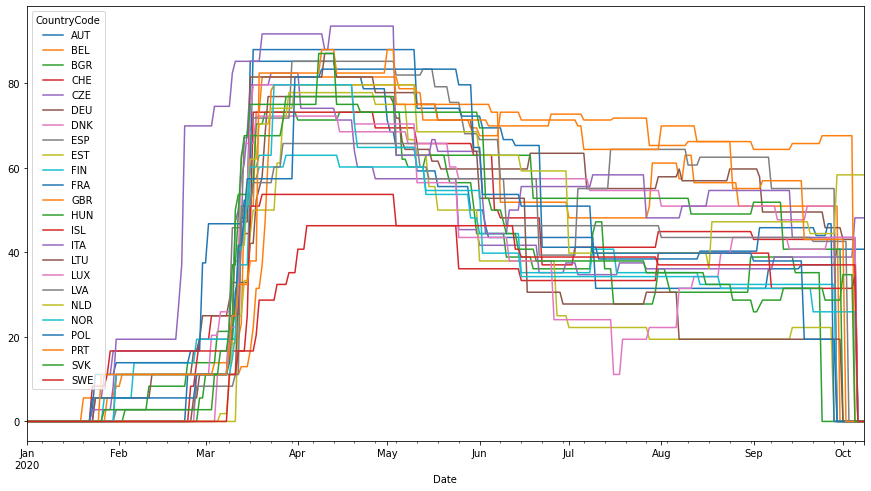

In [11]:
folder_response = "https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/"
file_response = "OxCGRT_latest.csv"
date_parser_response = lambda x: pd.datetime.strptime(str(x), "%Y%m%d")
response_df = pd.read_csv(folder_response + file_response, index_col="Date", parse_dates=["Date"], date_parser=date_parser_response)
indices_list = ["StringencyIndex"] #, "StringencyLegacyIndex", "GovernmentResponseIndex", "ContainmentHealthIndex", "EconomicSupportIndex"]

#r_df = response_df[response_df["CountryCode"].isin(a3_countries_list) & response_df["RegionCode"].isna()] # & response_df["CountryCode"]=="GBR"]
#a3_list = [c for c in a3_countries_list if c in list(r_df["CountryCode"])]
#print(a3_list, len(a3_list))

def get_lockdown_start(data, threshold=lockdown_treshold):
    for i in range(1,len(data) - 1):
        if data[i] >= threshold and data[i-1]<threshold:
            return i

oxford_indices_df = pd.DataFrame()
for index_key in indices_list:
    oxford_indices_df = response_df[response_df["CountryCode"].isin(a3_countries_list) & response_df["RegionCode"].isna()].groupby(["Date", "CountryCode"]).sum()[index_key].unstack()
    oxford_indices_df.plot(figsize=(15,8))
    
    

plt.savefig("figs/oxford_metric_{}.pdf".format(index_key))
response_df

/usr/lib/python3/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


{'AT': Timestamp('2020-03-13 00:00:00'), 'BE': Timestamp('2020-03-14 00:00:00'), 'BG': Timestamp('2020-03-13 00:00:00'), 'CH': Timestamp('2020-03-13 00:00:00'), 'CZ': Timestamp('2020-03-11 00:00:00'), 'DE': Timestamp('2020-03-16 00:00:00'), 'DK': Timestamp('2020-03-13 00:00:00'), 'EE': Timestamp('2020-03-16 00:00:00'), 'ES': Timestamp('2020-03-10 00:00:00'), 'FI': Timestamp('2020-03-16 00:00:00'), 'FR': Timestamp('2020-03-02 00:00:00'), 'HU': Timestamp('2020-03-11 00:00:00'), 'IT': Timestamp('2020-02-23 00:00:00'), 'IS': Timestamp('2020-03-16 00:00:00'), 'LT': Timestamp('2020-03-13 00:00:00'), 'LV': Timestamp('2020-03-13 00:00:00'), 'LU': Timestamp('2020-03-13 00:00:00'), 'NL': Timestamp('2020-03-12 00:00:00'), 'NO': Timestamp('2020-03-12 00:00:00'), 'PL': Timestamp('2020-03-12 00:00:00'), 'PT': Timestamp('2020-03-19 00:00:00'), 'SE': Timestamp('2020-04-01 00:00:00'), 'SK': Timestamp('2020-03-12 00:00:00'), 'UK': Timestamp('2020-03-21 00:00:00')}
{'AT': 85.19, 'BE': 81.48, 'BG': 73.15,

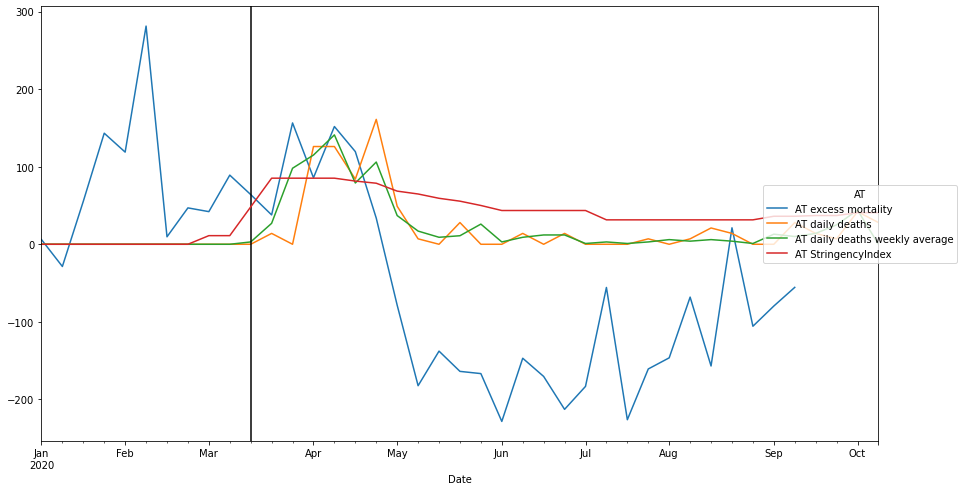

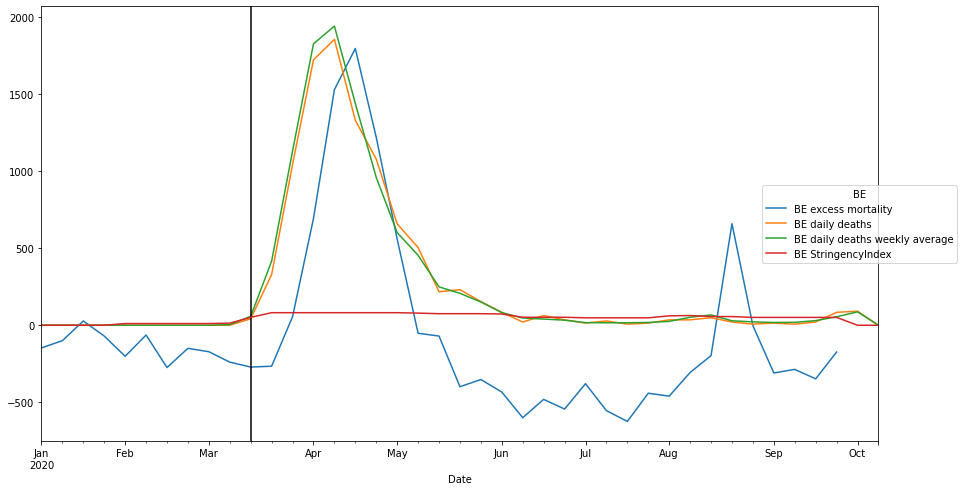

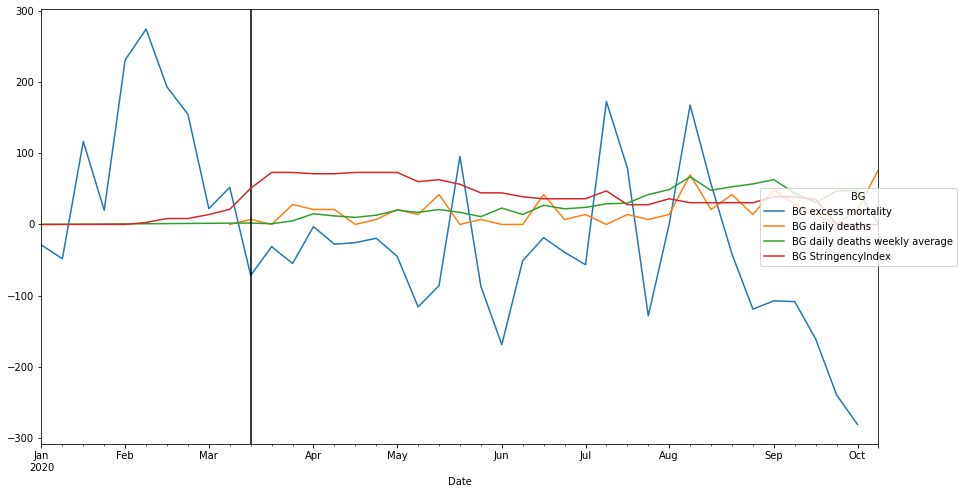

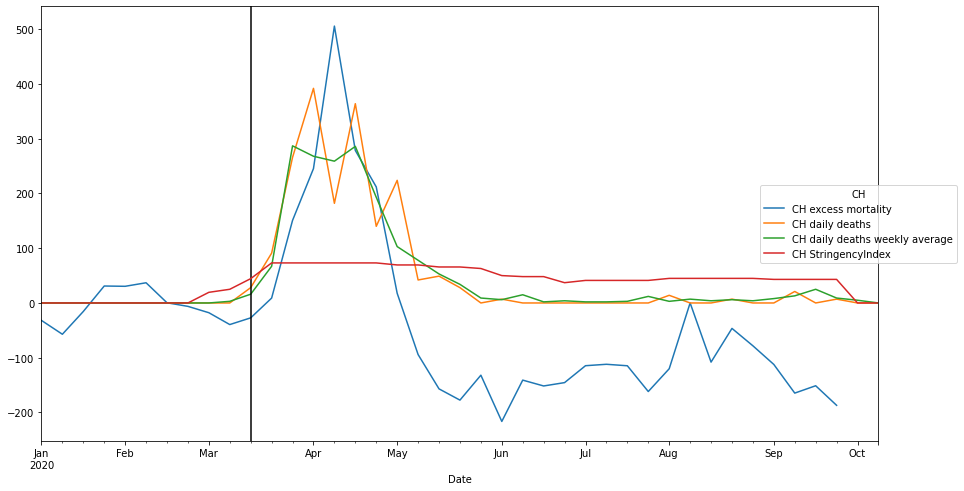

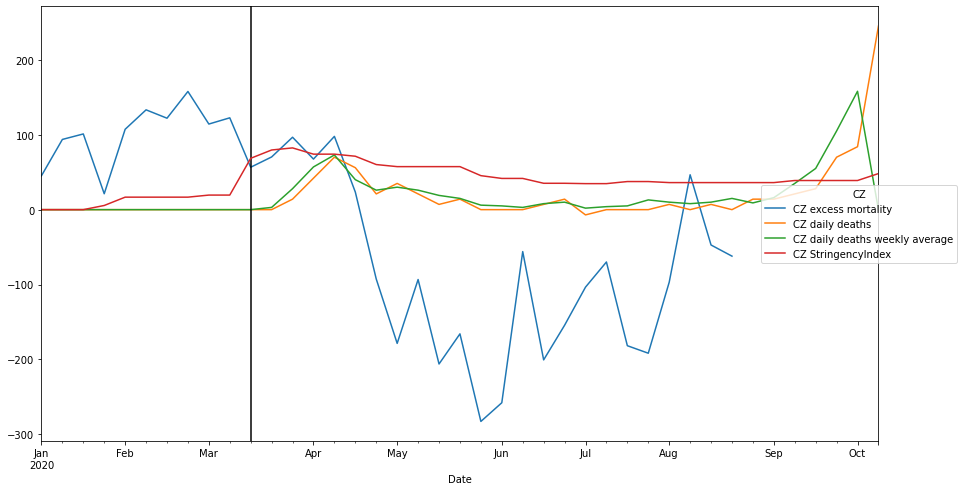

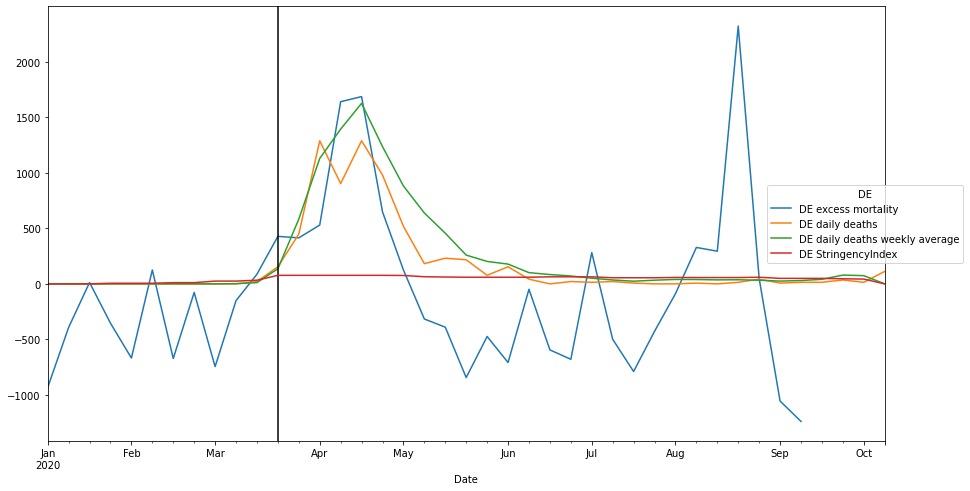

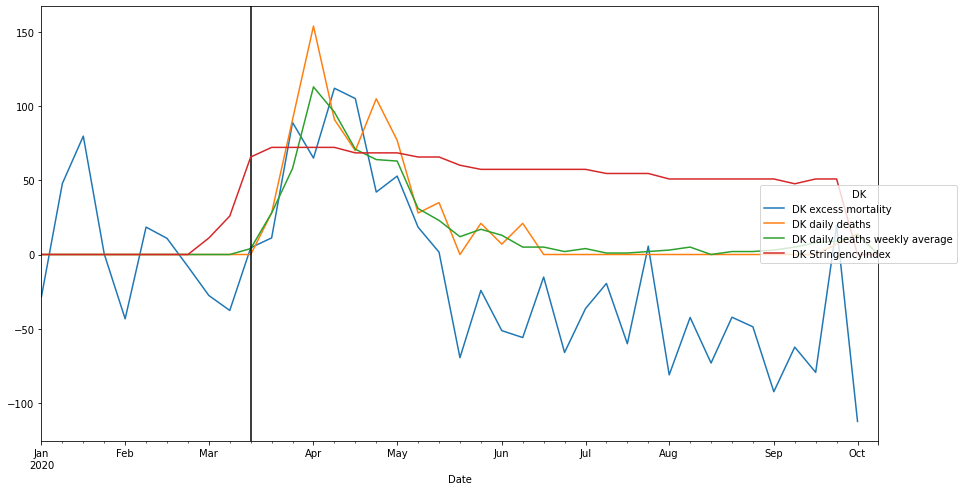

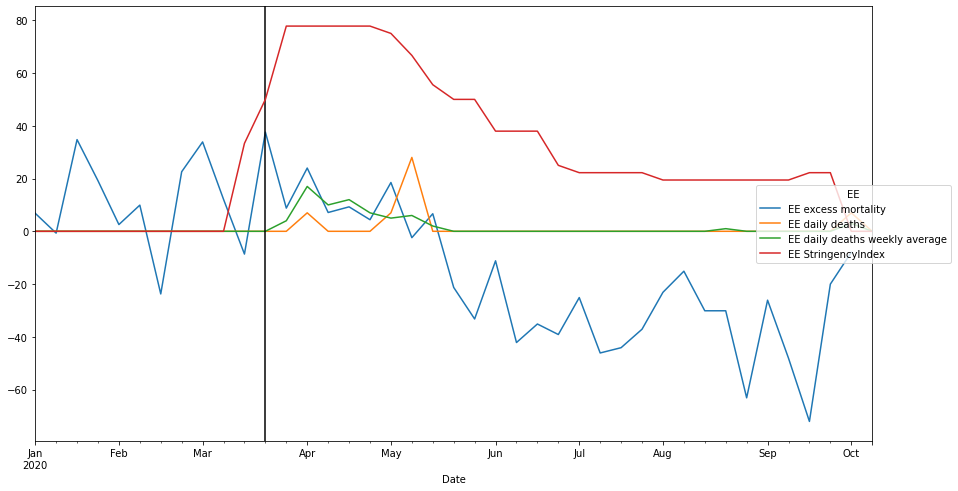

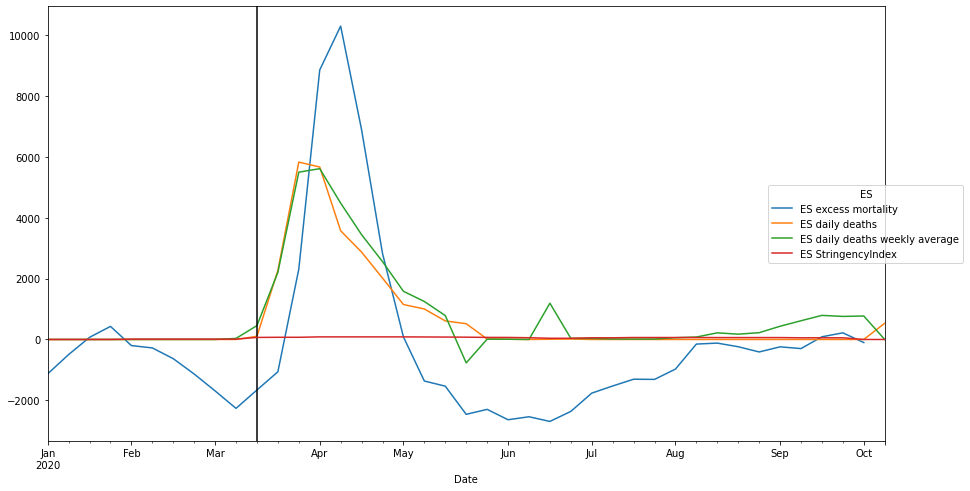

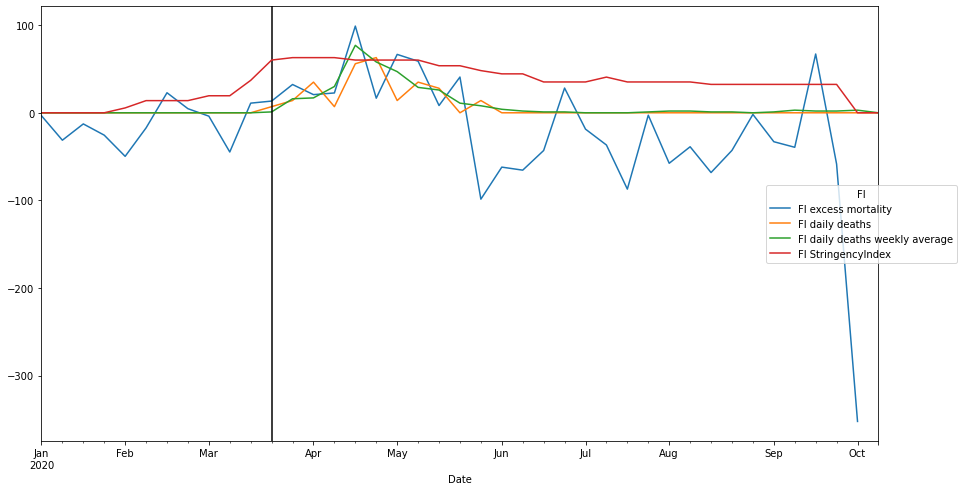

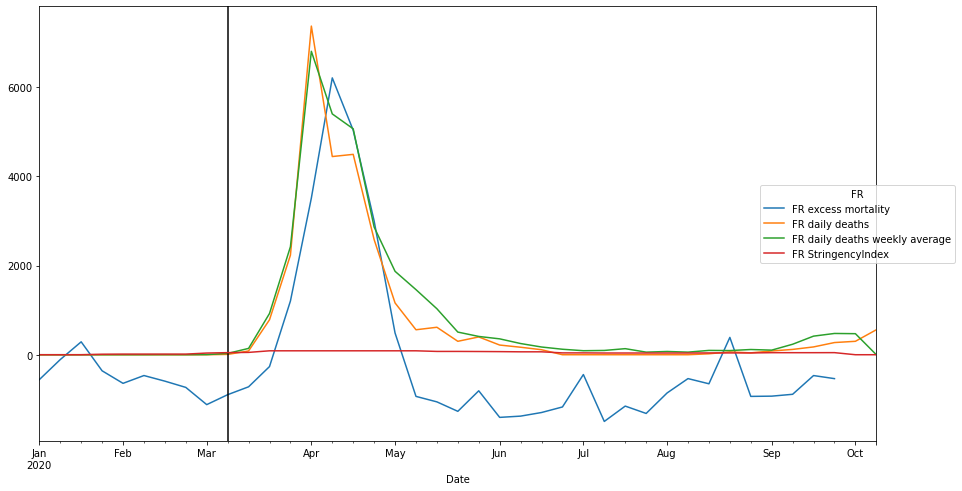

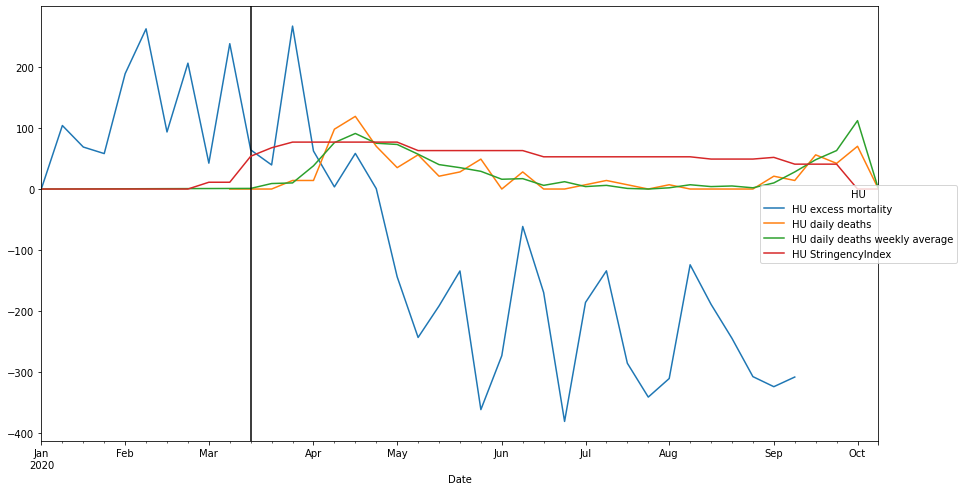

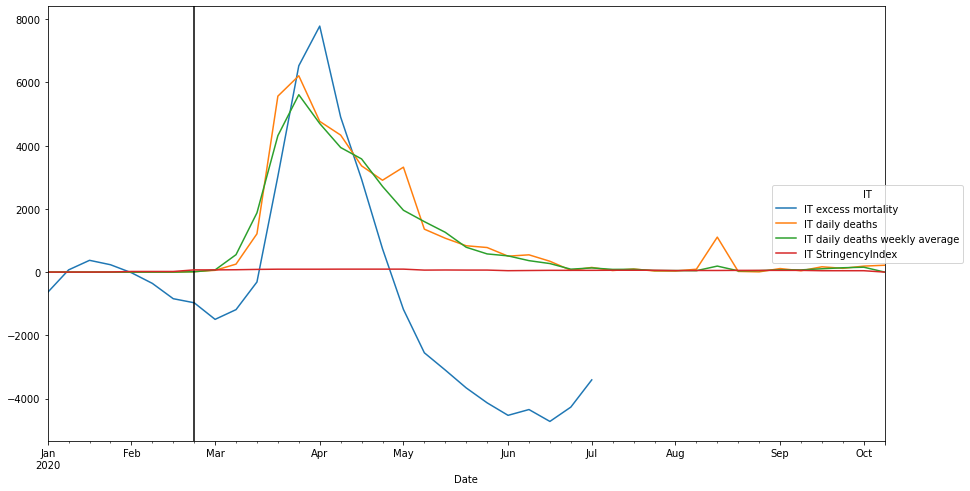

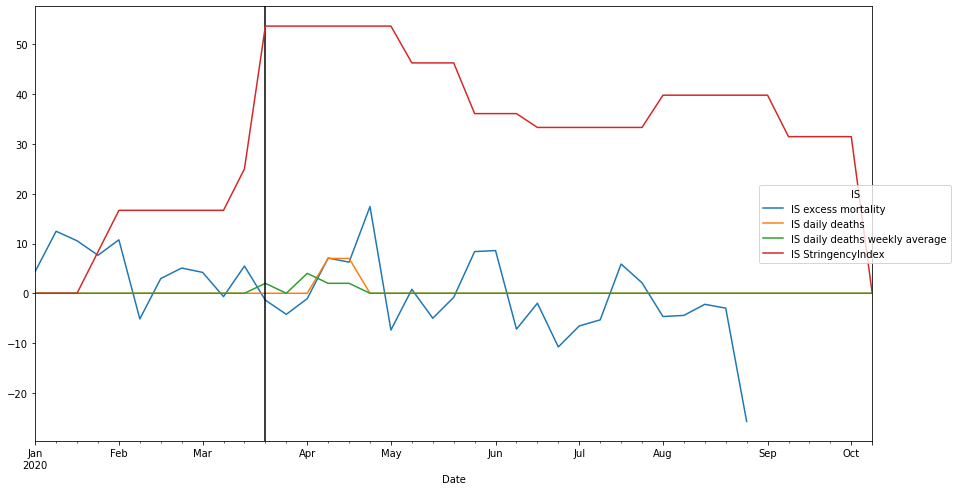

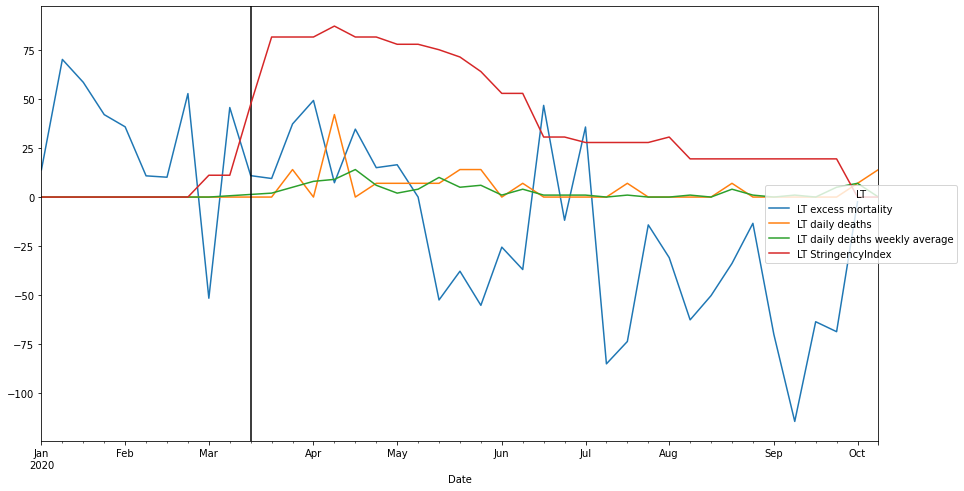

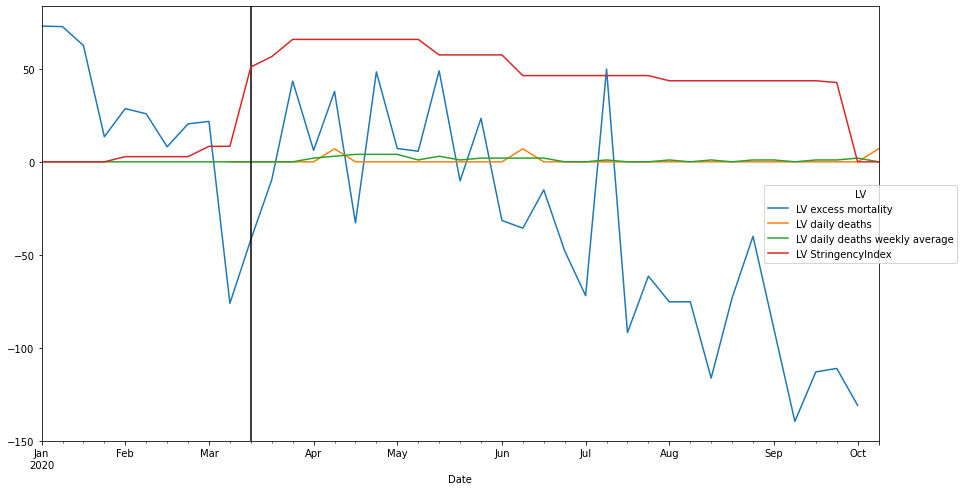

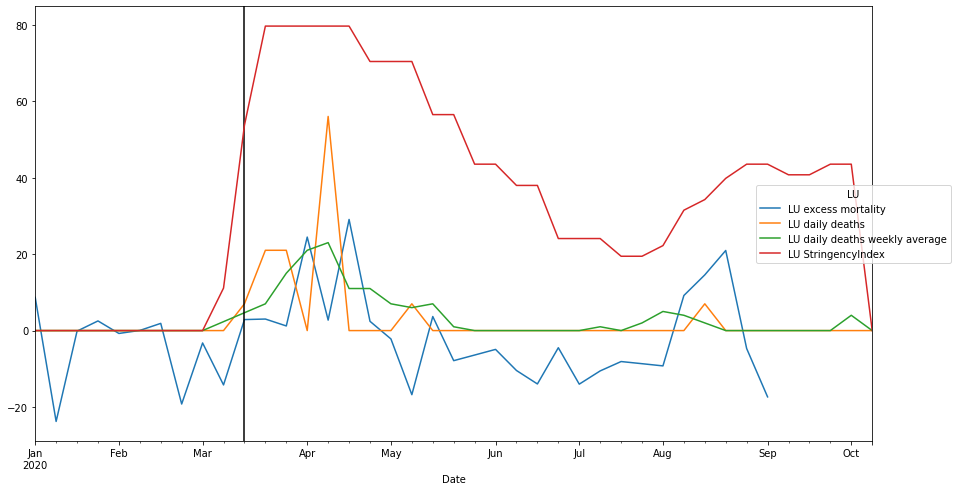

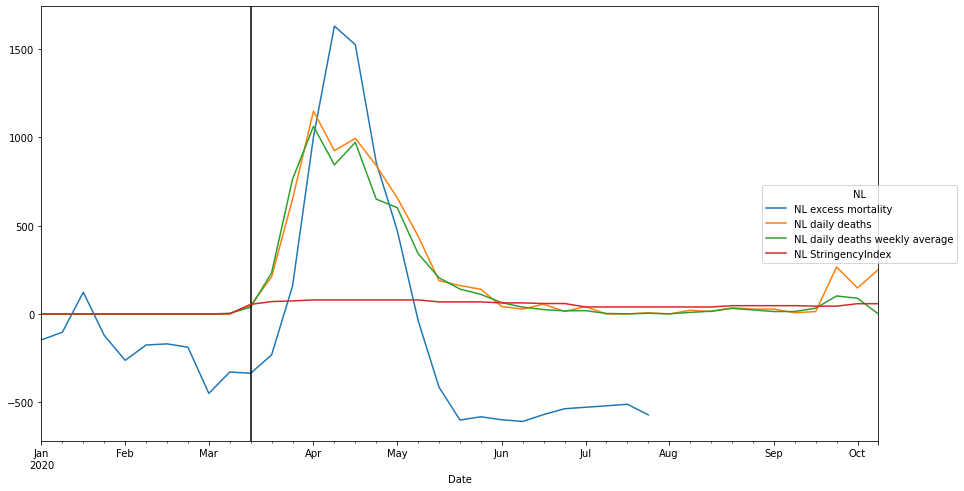

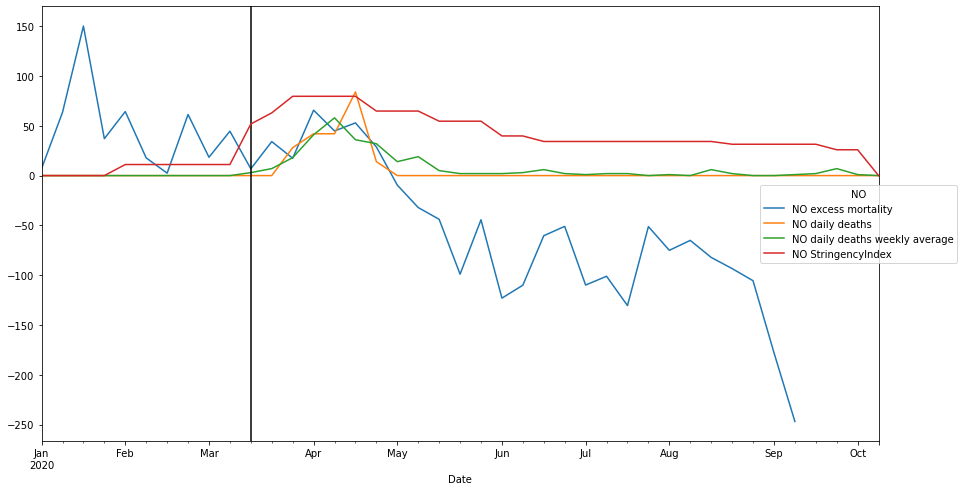

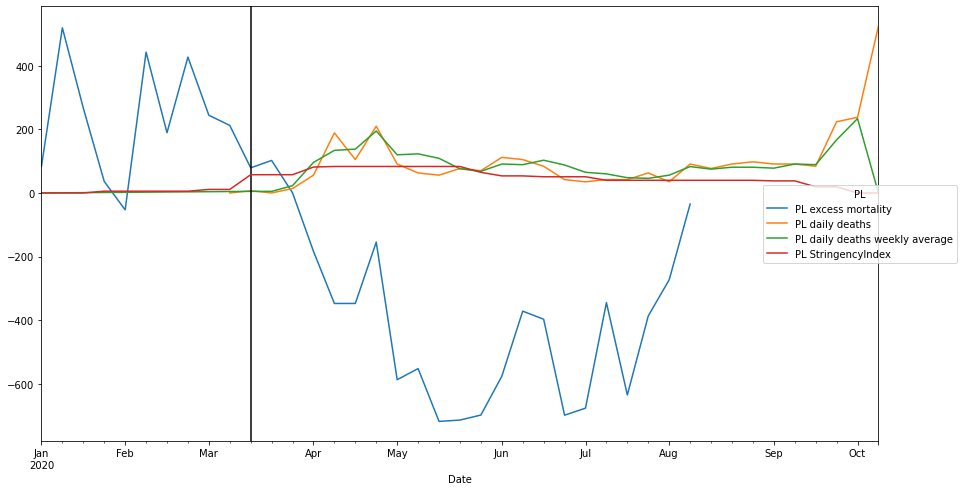

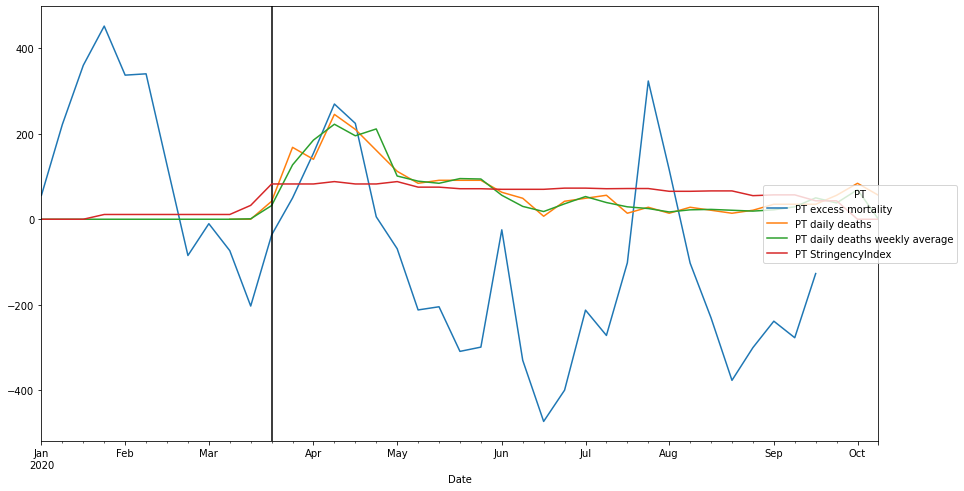

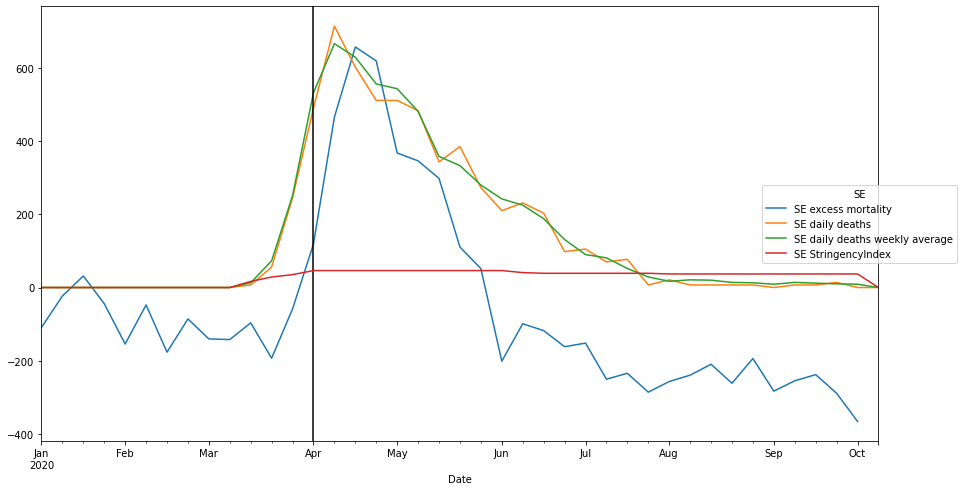

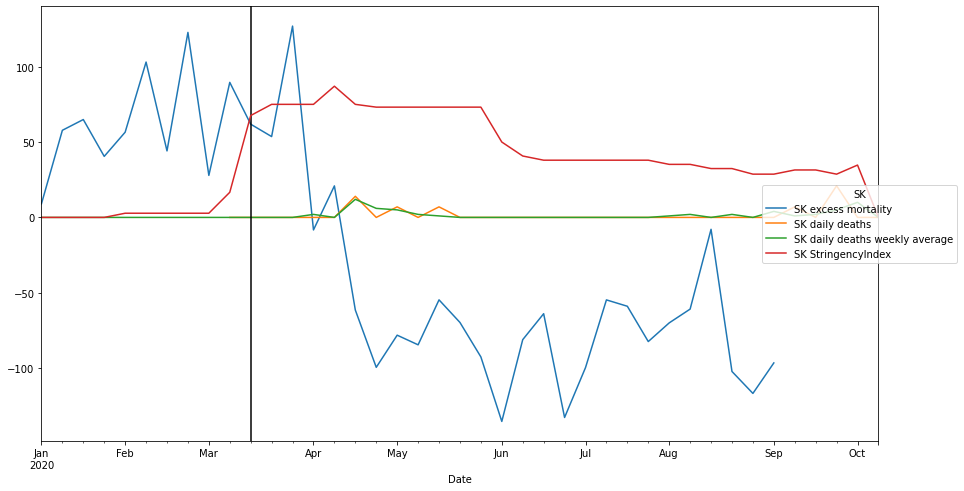

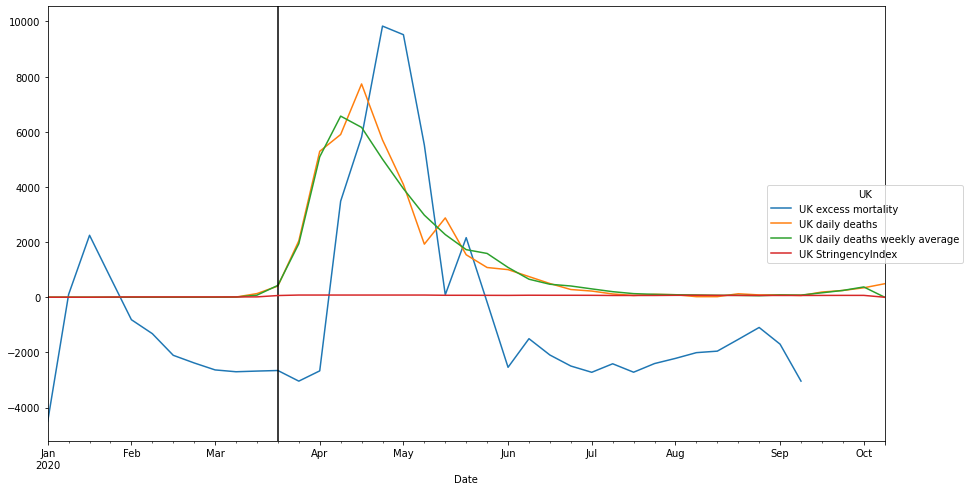

In [12]:
# fig, ax = plt.subplots()
lockdown_dates = {}
lockdown_strength = {}

view_start = "2020-01"
for country_index in range(len(countries_list)):
    
    fig, ax = plt.subplots()
    for index_key in indices_list[0:]:
        eu_weekly_df[countries_list[country_index]].loc[view_start:].sub(eu_weekly_df[countries_list[country_index] + "_filtered"].loc[view_start:], axis=0).plot(figsize=(15,8), ax=ax, label="{} excess mortality".format(countries_list[country_index]))
        (deaths_daily_df[countries_list[country_index]]*(2*avg_margin+1)).plot(ax=ax, label="{} daily deaths".format(countries_list[country_index]))
        (deaths_daily_smooth_df[countries_list[country_index]]*(2*avg_margin+1)).plot(ax=ax, label="{} daily deaths weekly average".format(countries_list[country_index]))
        #print(deaths_daily_smooth_df[countries_list[country_index]])

        
        oxford_indices_df = response_df[response_df["CountryCode"].isin(a3_countries_list) & response_df["RegionCode"].isna()].groupby(["Date", "CountryCode"]).sum()[index_key].unstack()
        ld = get_lockdown_start(oxford_indices_df[a3_countries_list[country_index]])
        lockdown_dates[countries_list[country_index]] = oxford_indices_df.index[ld]
        mld = max(oxford_indices_df[a3_countries_list[country_index]])
        lockdown_strength[countries_list[country_index]] = mld
        # print(oxford_indices_df.index[ld])
        # print(countries_list[country_index])
        # print(index_key)
        # print(ld)
        if type(ld) == int:
            plt.axvline(oxford_indices_df.index[ld], color="black")
        oxford_indices_df[a3_countries_list[country_index]].plot(ax=ax, label=countries_list[country_index] + " " + str(index_key))
        # plt.yscale("log")
        plt.legend(title=countries_list[country_index], loc="right", bbox_to_anchor=(1.1, 0.5))
        # print(countries_list[country_index], a3_countries_list[country_index])
        plt.savefig("figs/excess_mortality_{0}_oxford_metric_{1}.pdf".format(countries_list[country_index], index_key))
        # plt.close(fig)

print(lockdown_dates)
print(lockdown_strength)

    
# plt.yscale("log")
# plt.legend(loc="right", bbox_to_anchor=(1.1, 0.5))
# plt.savefig("figs/excess_mortality_fourier.pdf")



Index(['BG', 'CZ', 'HU', 'PL', 'SK'], dtype='object')
AxesSubplot(0.125,0.125;0.775x0.755)
27.36842105263158
26.0


<AxesSubplot:xlabel='days_diff', ylabel='lockdown_strength'>

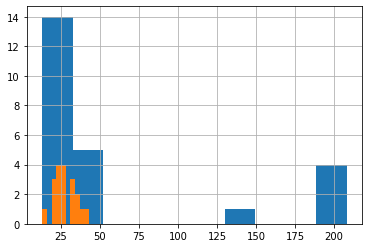

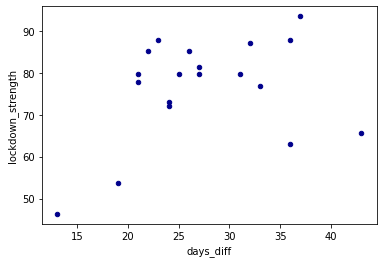

In [13]:
lockdown_df = pd.DataFrame(columns=["date_lockdown", "date_peak", "days_diff", "deaths14", "lockdown_strength"])
diff_list = []
for country in countries_list:
    date_lockdown = lockdown_dates[country]
    date_14_after = date_lockdown + pd.to_timedelta(14, unit="D")
    deaths14 = deaths_daily_df[country].loc[date_lockdown:date_14_after].sum()
    # date_peak = deaths_daily_smooth_df[country].loc["2020-02":"2020-06"].loc[deaths_daily_smooth_df[country].loc["2020-02":"2020-06"] == max(deaths_daily_smooth_df[country].loc["2020-02":"2020-06"].isfinite())]
    #print(deaths_daily_smooth_df[country]["2020-02":"2020-03"].isfinite())
    date_peak = deaths_daily_smooth_df[country].loc[deaths_daily_smooth_df[country] == max(deaths_daily_smooth_df[country])].index[0]
    days_diff = date_peak - date_lockdown
    diff_list.append(days_diff)#.append(days_diff.astype("days"))
    mld = lockdown_strength[country]
    lockdown_df.loc[country] = [date_lockdown, date_peak, days_diff, deaths14, mld]
    
lockdown_df["days_diff"].astype('timedelta64[D]').hist()
#plt.hist(diff_list)
print(lockdown_df[lockdown_df["days_diff"].astype('timedelta64[D]')>100].index)

lockdown_df.drop(index=lockdown_df[lockdown_df["days_diff"].astype('timedelta64[D]')>100].index, inplace=True)
# plt.figure()
print(lockdown_df["days_diff"].astype('timedelta64[D]').hist())
print(lockdown_df["days_diff"].astype('timedelta64[D]').mean())
print(lockdown_df["days_diff"].astype('timedelta64[D]').median())
lockdown_df["days_diff"] = lockdown_df["days_diff"].astype('timedelta64[D]')
lockdown_df.plot.scatter(x="days_diff",y="lockdown_strength",c="DarkBlue")


#deaths_daily_smooth_df[country]["2020-02":"2020-06"]